### Pre-installs

In [1]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install sklearn
# %pip install -U scikit-learn
# %pip install spotipy

### Input your data here

In [2]:
input = "Rap God"

### CSV & Spotify Information

In [3]:
import pandas as pd
import ast

# Importing the datasets
dataset = pd.read_csv("data/tracks_with_genres.csv")
df = pd.read_csv("data/tracks.csv")

# Creating the dataframe
df_generated = pd.DataFrame(dataset)
df_generated['genres'] = df_generated['genres'].apply(ast.literal_eval)

In [4]:
# Spotify API Authentication Information
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = '80e8701040fd4ee99393dbe0038161fb'
client_secret = 'e5b3e975af1a4ed8adac362bddbe98f3'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# # Assuming df_generated is your DataFrame
# # Adjust this part based on your actual DataFrame structure
# # For example, you might need to select specific columns or rows
# # or convert categorical variables to numerical values for visualization

# df_generated.columns
# df_graph = df_generated[['popularity', 'duration_ms', 'explicit',
#        'danceability', 'energy', 'key', 'loudness',
#        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
#        'valence', 'tempo', 'time_signature']]

# sns.set(style="white")  # Set the style of the plot

# # Create a heatmap using seaborn with annotated values for the entire correlation matrix
# plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
# heatmap = sns.heatmap(df_graph.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# # Customize the appearance of the heatmap
# heatmap.set_title('Heatmap of df_generated', fontsize=16)

# plt.show()

### Processing the Input Song

In [6]:
# Using Spotify API to search for a song's information based on input and adding the necessary information in a DataFrame.
def search_track(track_name):
    # Search for the track
    results = sp.search(q=track_name, type='track')

    # Check if the track exists
    if results['tracks']['total'] > 0:
        # Get the first track from the results
        track = results['tracks']['items'][0]
        explicit = int(track["explicit"] == True)
        print(f'Found track: {track["name"]} by {track["artists"][0]["name"]} from the album {track["album"]["name"]}.')
        track_dict = {"id": track["id"], "name": track["name"], "popularity": track["popularity"], 
                      "duration_ms": track["duration_ms"], "explicit": explicit, "artists": track["artists"][0]["name"],
                      "id_artists": track["artists"][0]["id"], "release_date": track["album"]["release_date"]}
        return track_dict
    else:
        print('Track not found')
        return None

# Creating a Single Row DataFrame for the input song.
track_result = search_track(input)
td = pd.DataFrame(track_result, index=[0])
td

Found track: Rap God by Eminem from the album The Marshall Mathers LP2 (Deluxe).


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date
0,6or1bKJiZ06IlK0vFvY75k,Rap God,80,363521,1,Eminem,7dGJo4pcD2V6oG8kP0tJRR,2013-11-05


In [7]:
# Obtaining Feature Data from song based on its song_id from previous function and adding them to a DataFrame.
def get_audio_features(track_result):
    song_id = track_result["id"]
    results = sp.audio_features(song_id)

    if results:
        return results[0]
    else:
        print(f'No audio features found for song ID: {song_id}')
        return None

audio_features = get_audio_features(track_result)
af = pd.DataFrame(audio_features, index=[0])
# Taking out the irrevelant features.
af_formatted = af.drop(["type", "id", "uri", "track_href", "analysis_url", "duration_ms"], axis=1)
# Merging both DataFrames to sync up with the dataset's layout.
td = pd.concat([td, af_formatted], axis=1)
td['year'] = td['release_date'].str.extract(r'(\d{4})').astype(int)

In [8]:
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,6or1bKJiZ06IlK0vFvY75k,Rap God,80,363521,1,Eminem,7dGJo4pcD2V6oG8kP0tJRR,2013-11-05,0.708,0.843,...,-2.66,1,0.314,0.397,0,0.799,0.625,148.14,4,2013


In [9]:
import ast

td['artists'] = "['" + td['artists'] + "']"
td['artists'] = td['artists'].apply(ast.literal_eval)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,6or1bKJiZ06IlK0vFvY75k,Rap God,80,363521,1,[Eminem],7dGJo4pcD2V6oG8kP0tJRR,2013-11-05,0.708,0.843,...,-2.66,1,0.314,0.397,0,0.799,0.625,148.14,4,2013


In [10]:
td['artists_count'] = len(td['artists'])
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count
0,6or1bKJiZ06IlK0vFvY75k,Rap God,80,363521,1,[Eminem],7dGJo4pcD2V6oG8kP0tJRR,2013-11-05,0.708,0.843,...,1,0.314,0.397,0,0.799,0.625,148.14,4,2013,1


In [11]:
expanded_artists = td['artists'].apply(lambda x: pd.Series(x))

# Rename the columns
expanded_artists.columns = [f"artist_{i+1}" for i in range(len(expanded_artists.columns))]

# Concatenate the expanded columns with the original DataFrame
td = pd.concat([td, expanded_artists], axis=1)
td.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1
0,6or1bKJiZ06IlK0vFvY75k,Rap God,80,363521,1,[Eminem],7dGJo4pcD2V6oG8kP0tJRR,2013-11-05,0.708,0.843,...,0.314,0.397,0,0.799,0.625,148.14,4,2013,1,Eminem


In [12]:
def get_artist_genres(artist_name):
    try:
        results = sp.search(q='artist:' + artist_name, type='artist')
        genres = results['artists']['items'][0]['genres']
        return genres if genres else []
    except IndexError:
        return []
    
for i in range(len(td['artists_count'])):
    td['genres'] = td['artist_' + str(i+1)].apply(get_artist_genres)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1,genres
0,6or1bKJiZ06IlK0vFvY75k,Rap God,80,363521,1,[Eminem],7dGJo4pcD2V6oG8kP0tJRR,2013-11-05,0.708,0.843,...,0.397,0,0.799,0.625,148.14,4,2013,1,Eminem,"[detroit hip hop, hip hop, rap]"


### Adding Input to Dataset and further processing

In [13]:
# Adding the Input Song to the Dataset DataFrame. Added to the very front.
new_df = pd.concat([td, df_generated], ignore_index=True)
new_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,tempo,time_signature,year,artists_count,artist_1,genres,song_name_artist,artist_2,artist_3,artist_4
0,6or1bKJiZ06IlK0vFvY75k,Rap God,80,363521,1,[Eminem],7dGJo4pcD2V6oG8kP0tJRR,2013-11-05,0.708,0.843,...,148.140,4,2013,1,Eminem,"[detroit hip hop, hip hop, rap]",NaN,NaN,NaN,NaN
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,...,113.564,3,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",You'll Never Walk Alone - Mono; 2002 Remaster[...,NaN,NaN,NaN
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[],A Lover's Concerto['The Toys'],NaN,NaN,NaN
3,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[thai pop],A Lover's Concerto['The Toys'],NaN,NaN,NaN
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,...,104.536,4,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Ferry Cross the Mersey - Mono; 2002 Remaster['...,NaN,NaN,NaN


In [14]:
new_df['song_id_name'] = new_df['id'] + new_df['name']
print(new_df.shape)
new_df.drop_duplicates(subset=["song_id_name"], keep='first', inplace=True)
print(new_df.shape)

(228030, 29)
(186011, 29)


In [15]:
def count_items_in_list(lst):
    return len(lst)

# Apply the function to the DataFrame column
new_df['genres_count'] = new_df['genres'].apply(count_items_in_list)
new_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,year,artists_count,artist_1,genres,song_name_artist,artist_2,artist_3,artist_4,song_id_name,genres_count
0,6or1bKJiZ06IlK0vFvY75k,Rap God,80,363521,1,[Eminem],7dGJo4pcD2V6oG8kP0tJRR,2013-11-05,0.708,0.843,...,2013,1,Eminem,"[detroit hip hop, hip hop, rap]",NaN,NaN,NaN,NaN,6or1bKJiZ06IlK0vFvY75kRap God,3
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",You'll Never Walk Alone - Mono; 2002 Remaster[...,NaN,NaN,NaN,6catF1lDhNTjjGa2GxRQNNYou'll Never Walk Alone ...,9
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,2020,1,The Toys,[],A Lover's Concerto['The Toys'],NaN,NaN,NaN,6Pkt6qVikqPBt9bEQy8iTzA Lover's Concerto,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Ferry Cross the Mersey - Mono; 2002 Remaster['...,NaN,NaN,NaN,4aSw1QJIMwYSoDEgzgdCJLFerry Cross the Mersey -...,9
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,34,157093,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.477,0.352,...,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Don't Let the Sun Catch You Crying (Main) - Mo...,NaN,NaN,NaN,0ZMMtH875IR2TfkyC4PolDDon't Let the Sun Catch ...,9


In [16]:
print(new_df.shape)
new_df = new_df[(new_df['genres_count'] != 0)]
print(new_df.shape)

(186011, 30)
(166251, 30)


### Supersetting genres

In [17]:
# Determining the frequency of the genre. Giving the input song's genre priority to go first.
genre_extract = new_df['genres'].reset_index()
genre_wo_index = genre_extract['genres']
tally = genre_wo_index.count()
genre_dict = {}

for i in range (tally):
    input = genre_wo_index.loc[i]
    if len(input) > 0:
        for n in input:
            if n in genre_dict.keys():
                genre_dict[n] += 1
            else:
                genre_dict[n] = 1

print(genre_dict)

{'detroit hip hop': 235, 'hip hop': 2814, 'rap': 3210, 'folk rock': 933, 'british invasion': 495, 'merseybeat': 529, 'rock-and-roll': 650, 'rockabilly': 550, 'classic uk pop': 704, 'adult standards': 1216, 'bubblegum pop': 416, 'brill building pop': 763, 'lounge': 283, 'easy listening': 126, 'canadian blues': 54, 'british blues': 265, 'mellow gold': 1141, 'lilith': 307, 'singer-songwriter': 312, 'canadian singer-songwriter': 107, 'folk': 393, 'rock': 3193, 'harlem renaissance': 23, 'big band': 94, 'stride': 75, 'cool jazz': 274, 'jazz': 304, 'swing': 56, 'jazz piano': 73, 'vocal jazz': 355, 'contemporary jazz': 73, 'jazz saxophone': 71, 'swedish jazz': 134, 'jazz quartet': 20, 'avant-garde jazz': 49, 'contemporary post-bop': 57, 'italian jazz': 15, 'jazz fusion': 297, 'free jazz': 58, 'classic soundtrack': 89, 'italian soundtrack': 28, 'vintage italian soundtrack': 34, 'soundtrack': 456, 'hard bop': 204, 'jazz trumpet': 176, 'psychedelic rock': 592, 'roots rock': 250, 'acid rock': 67, 

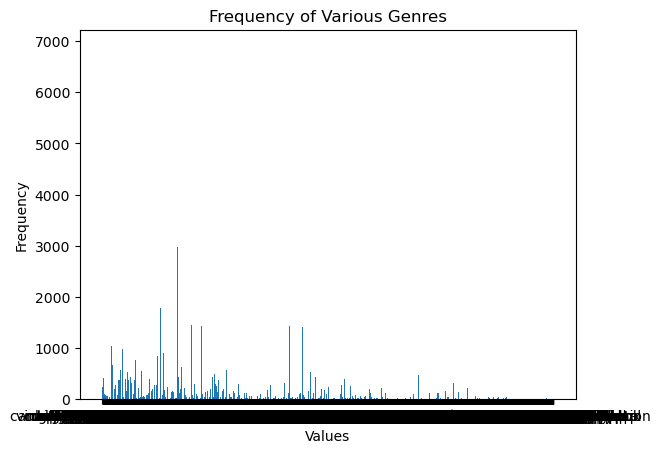

In [18]:
import matplotlib.pyplot as plt

# Plot the frequency distribution
plt.bar(genre_dict.keys(), genre_dict.values())
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Frequency of Various Genres')
plt.show()

In [19]:
genres_df = pd.Series(genre_dict)
genres_df.head()

detroit hip hop      235
hip hop             2814
rap                 3210
folk rock            933
british invasion     495
dtype: int64

In [ ]:
# Summary Statistics of genres.
genres_df.T.describe()

In [21]:
# genres_df.to_csv("data/genre_frequency.csv")

In [22]:
# Frequency tabulation of all superset genres. With priority given to the input song.

from collections import defaultdict

def group_into_supersets(genre_dict):
    supersets = defaultdict(int)

    for genre, frequency in genre_dict.items():
        matched = False
        for superset in supersets:
            if any(subset in genre for subset in superset.split()):
                supersets[superset] += frequency
                matched = True
                break
        if not matched:
            supersets[genre] += frequency

    return supersets

# Group into supersets
supersets = group_into_supersets(genre_dict)

# Output the result
for superset, frequency in supersets.items():
    print(f"{superset}: {frequency}")

detroit hip hop: 39792
rap: 35009
folk rock: 77217
british invasion: 1309
merseybeat: 529
classic uk pop: 150189
adult standards: 1219
lounge: 343
easy listening: 144
canadian blues: 2194
mellow gold: 2277
lilith: 307
singer-songwriter: 3374
harlem renaissance: 23
big band: 3086
stride: 75
cool jazz: 5430
swing: 697
contemporary post-bop: 2611
italian soundtrack: 2000
hard bop: 1769
motown: 177
soul: 3041
beatlesque: 95
cabaret: 175
freakbeat: 40
protopunk: 50
oklahoma country: 2995
experimental: 171
late romantic era: 5124
orchestral performance: 575
french orchestra: 2208
compositional ambient: 405
funk: 2823
nashville sound: 386
permanent wave: 1875
alternative metal: 17149
post-grunge: 615
ancient mediterranean: 653
reggae fusion: 8651
hyphy: 65
wrestling: 113
eurodance: 745
zolo: 34
post-punk: 272
miami indie: 11996
industrial techno: 1360
minimal dub: 368
brostep: 166
bassline: 72
edm: 5123
electro house: 15687
old school dancehall: 1241
ragga jungle: 206
ska: 1588
regional mexic

In [23]:
print(len(supersets.keys()))

357


In [24]:
# Creating the genre supersets, with priority to the input song's genre.
# Since the input song is the first one to be run, its genre will be able to start the classification of other sub-genres under it.

# This can be further improved. Allowing for later genres to take over earlier genres as the superset if it more general.
# E.g.: Detroit Hip Hop is found before general hip hop. Currently they will be seperated into 2 seperate genres because the first word 'detroit' is
# not 'hip hop' and is thus overlooked.

def generate_superset_mapping(genre_dict):
    superset_mapping = {}

    for genre, frequency in genre_dict.items():
        superset_found = False
        for superset in superset_mapping:
            if any(subset in genre for subset in superset_mapping[superset]):
                superset_mapping[superset].append(genre)
                superset_found = True
                break
        if not superset_found:
            superset_mapping[genre] = [genre]

    return superset_mapping

# Generate superset mapping
superset_mapping = generate_superset_mapping(genre_dict)

# Output the superset mapping
for superset, subsets in superset_mapping.items():
    print(f"{superset}: {subsets}")

detroit hip hop: ['detroit hip hop']
hip hop: ['hip hop', 'atl hip hop', 'southern hip hop', 'finnish hip hop', 'south african hip hop', 'conscious hip hop', 'political hip hop', 'irish hip hop', 'hardcore hip hop', 'east coast hip hop', 'alternative hip hop', 'dutch hip hop', 'psychedelic hip hop', 'tennessee hip hop', 'memphis hip hop', 'underground hip hop', 'miami hip hop', 'harlem hip hop', 'jewish hip hop', 'german hip hop', 'latin hip hop', 'brazilian hip hop', 'oakland hip hop', 'french hip hop', 'bronx hip hop', 'queens hip hop', 'south carolina hip hop', 'virginia hip hop', 'indie hip hop', 'spanish hip hop', 'hamburg hip hop', 'christian hip hop', 'old school hip hop', 'mexican hip hop', 'birmingham hip hop', 'thai hip hop', 'turkish hip hop', 'desi hip hop', 'pinoy hip hop', 'mississippi hip hop', 'japanese old school hip hop', 'north carolina hip hop', 'nashville hip hop', 'asian american hip hop', 'abstract hip hop', 'cologne hip hop', 'uk hip hop', 'bay area hip hop', 's

In [25]:
# Now with the superset mapped out, apply it onto the all the songs to determine their supersetted genre(s).
# This can be improved. Instead of only returning the first superset genre, it should return multiple in an array.

import pandas as pd

genres_df = pd.DataFrame(genres_df, columns=['genres'])

def group_into_supersets(new_df, superset_mapping):
    def get_superset(genres):
        for superset, subsets in superset_mapping.items():
            if any(subset in genre for genre in genres for subset in subsets):
                return superset
        return 'other'  # If no superset is found

    new_df['supersetted_genres'] = new_df['genres'].apply(get_superset)
    return new_df

# Group into supersets and create new column
new_df = group_into_supersets(new_df, superset_mapping)

In [26]:
new_df['supersetted_genres'].value_counts().count()

892

### Encoding

In [27]:
# One-hot Encoding of all the superset genres of each song in the dataframe.

genres_dummies = pd.get_dummies(new_df['supersetted_genres'].apply(pd.Series).stack()).groupby(level=0).sum()

# Concatenate the binary columns with the original DataFrame
df_2 = pd.concat([new_df, genres_dummies], axis=1)

In [28]:
# Removing unnecessary features.

df_2 = df_2.drop(['id_artists', 'release_date', 'popularity', 'mode', 'artists_count', 'song_name_artist', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'genres', 'supersetted_genres'], axis=1)
df_2.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,yoga,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk
0,6or1bKJiZ06IlK0vFvY75k,Rap God,363521,1,[Eminem],0.708,0.843,7,-2.660,0.3140,...,0,0,0,0,0,0,0,0,0,0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,0,NaN,0.484,0.265,0,-11.101,0.0322,...,0,0,0,0,0,0,0,0,0,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,0,NaN,0.405,0.365,6,-10.226,0.0289,...,0,0,0,0,0,0,0,0,0,0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,0,NaN,0.477,0.352,1,-14.165,0.0300,...,0,0,0,0,0,0,0,0,0,0
6,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,187333,0,NaN,0.319,0.201,7,-17.796,0.0623,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Filling in any null values. (In case)

df_2 = df_2.fillna(0)
df_2.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,yoga,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk
0,6or1bKJiZ06IlK0vFvY75k,Rap God,363521,1,[Eminem],0.708,0.843,7,-2.660,0.3140,...,0,0,0,0,0,0,0,0,0,0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,0,0,0.484,0.265,0,-11.101,0.0322,...,0,0,0,0,0,0,0,0,0,0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,0,0,0.405,0.365,6,-10.226,0.0289,...,0,0,0,0,0,0,0,0,0,0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,0,0,0.477,0.352,1,-14.165,0.0300,...,0,0,0,0,0,0,0,0,0,0
6,1hx7X9cMXHWJjknb9O6Ava,The September Of My Years - Live At The Sands ...,187333,0,0,0.319,0.201,7,-17.796,0.0623,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_2.shape

(166251, 911)

### Cosine Similarity & Output Extraction

In [31]:
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Feature selection, removing non-useful rows.
def processing(df_2):
    # Normalize numerical features
    numerical_features = ['duration_ms', 'loudness', 'tempo']
    scaler = MinMaxScaler()
    df_2[numerical_features] = scaler.fit_transform(df_2[numerical_features])
    
    # Standardize Year
    df_2['standardized_year'] = scaler.fit_transform(df_2[['year']])
    df_2 = df_2.drop(['year'], axis=1)

    # Create a feature matrix
    feature_matrix = df_2.drop(['id', 'name', 'artists', 'song_id_name', 'explicit', 'time_signature'], axis=1)

    # Apply normalization to the entire feature matrix
    feature_matrix = scaler.fit_transform(feature_matrix)

    # This is the input song. We are isolating it from the dataframe first.
    input_song = feature_matrix[0]
    
    arr = []

    # Returns comparison value of first song in dataset to all others in an array.
    # DataFrame can be customized before Feature Selection to change which song the subject of comparison should be.
    for i in range(1, len(feature_matrix)):
        # Take the i-th song from the feature matrix
        compare_song = feature_matrix[i]
        # Perform cosine similarity.
        cosine_sim = cosine_similarity([input_song], [compare_song])
        cs_value = cosine_sim[0][0]  # Take the single similarity value between the input song and the i-th song.
        arr.append(cs_value)

    return arr

arr = processing(df_2)
arr

[0.6085256294360329,
 0.6835363531877069,
 0.639042285954345,
 0.6945680758611952,
 0.6486317397189068,
 0.7290834651505853,
 0.7383893827483425,
 0.6275353705348736,
 0.6627973795978717,
 0.7107812017616191,
 0.6790820566947195,
 0.6482165336917752,
 0.730896078993718,
 0.5863654416016814,
 0.7318375735277356,
 0.605815926415286,
 0.7463635239684063,
 0.6916087875490843,
 0.6931905231507991,
 0.68690793709559,
 0.6548906295546442,
 0.7074953503817539,
 0.7416334415362535,
 0.6745356755650938,
 0.7179927049986161,
 0.7244817151146343,
 0.6340860506250021,
 0.6660403875292306,
 0.6112546841386419,
 0.6643468664379298,
 0.6593939130014397,
 0.6654254604450922,
 0.6943359919900135,
 0.6780819284768881,
 0.7212001851748755,
 0.7664517314619832,
 0.7123920496855978,
 0.6717799485795918,
 0.7295017499540373,
 0.7398032689333769,
 0.6780224259923322,
 0.6958712525824073,
 0.7478004180976754,
 0.6777588316321537,
 0.6938854925126128,
 0.6956189777972817,
 0.7445399250850306,
 0.688312781009682

In [32]:
max(arr[1:])

0.9814292713697259

In [33]:
def compile_suggestions(arr):
    suggestions = []
    
    # Compiling all song ids that are above the pre-determined threshold for 'like the first song'.
    for i in range(len(arr)):
        if arr[i] > 0.9:
            suggestions.append(i)
    
    print(suggestions)
    return suggestions
suggestions = compile_suggestions(arr)

[314, 362, 380, 530, 682, 733, 965, 1571, 1608, 1619, 1720, 1743, 1782, 1850, 1895, 1978, 2111, 2442, 3078, 3092, 3112, 3319, 3394, 3513, 3753, 4018, 4494, 4864, 5220, 6715, 6720, 6730, 6756, 6917, 7457, 7468, 7544, 7546, 7552, 7572, 7650, 7750, 7917, 7929, 7939, 8108, 8210, 8435, 8901, 8960, 9073, 9233, 9438, 9664, 9909, 9941, 9992, 10114, 10180, 10212, 10288, 10303, 10534, 10911, 11224, 12580, 13165, 13255, 13310, 13949, 14147, 14196, 14970, 15381, 15536, 15655, 17075, 17151, 17162, 17222, 17432, 17443, 17445, 17503, 17513, 17529, 17664, 18466, 18560, 18640, 18674, 18761, 18795, 18814, 19001, 19524, 20018, 20567, 21272, 22331, 22462, 22640, 23159, 23597, 23663, 23680, 23684, 24591, 30139, 32001, 33098, 33634, 33772, 33946, 33984, 33999, 34100, 34160, 34281, 34289, 34297, 34478, 34500, 34569, 34778, 34779, 34781, 34798, 34819, 34833, 34834, 35344, 35421, 35564, 36009, 36115, 49482, 49681, 49909, 51589, 55875, 67019, 68162, 68738, 68790, 68858, 68867, 68967, 69352, 69480, 69901, 70095,

In [34]:
len(suggestions)

176

In [35]:
# Extracting out the end result information.
df_main = df_2[df_2.index.isin(suggestions)]

df_main.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,zen,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk,standardized_year
314,7HjJCI3OUkNjbjb7fShyya,This Thing Called Love - Stereo; 2002 Remaster,0.025634,0,0,0.413,0.414,4,0.739778,0.0380,...,0,0,0,0,0,0,0,0,0,0.380952
362,6mpRZ6nqlTVK1YyxMy3PTm,Lyres of the Levites (Composition For Replica ...,0.048909,0,0,0.452,0.155,9,0.663999,0.1090,...,0,0,0,0,0,0,0,0,0,0.523810
380,1s5Lmrm3M6yIaMdR8185pk,Rock It Tonight - Year 3000 Mix,0.067145,0,0,0.525,0.970,1,0.922042,0.0627,...,0,0,0,0,0,0,0,0,0,0.857143
682,18ohWhzbMCynq5QJ68ifkW,Criminal,0.063057,1,0,0.810,0.724,4,0.856700,0.2680,...,0,0,0,0,0,0,0,0,0,0.000000
733,1vt0n3GcAYrsSMue1C6OtC,Samba De Verao,0.036610,0,0,0.731,0.299,5,0.680959,0.0485,...,0,0,0,0,0,0,0,0,0,0.000000


In [36]:
df_main.count() # There is one less for the last 3 features as the input song did not go through the extracted year's steps.
# df_final['standardized_year'].describe()

id                   131
name                 131
duration_ms          131
explicit             131
artists              131
                    ... 
zim urban groove     131
zolo                 131
zouglou              131
zouk                 131
standardized_year    131
Length: 912, dtype: int64

In [37]:
df_main = df_main.iloc[1:]

df_main = df_main.drop('artists', axis=1)

id_artist_mapping = df.set_index('id')['artists'].to_dict()

# Add 'artist' column to df1 using the mapping
df_main['artists'] = df_main['id'].map(id_artist_mapping)
df_main.head()

,id,name,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,...,zespol dzieciecy,zhongguo feng,zikir,zillertal,zim urban groove,zolo,zouglou,zouk,standardized_year,artists
362,6mpRZ6nqlTVK1YyxMy3PTm,Lyres of the Levites (Composition For Replica ...,0.048909,0,0.452,0.155,9,0.663999,0.1090,0.987000,...,0,0,0,0,0,0,0,0,0.523810,['Michael Levy']
380,1s5Lmrm3M6yIaMdR8185pk,Rock It Tonight - Year 3000 Mix,0.067145,0,0.525,0.970,1,0.922042,0.0627,0.000109,...,0,0,0,0,0,0,0,0,0.857143,"['Johnny Osbourne', 'Marcus Visionary']"
682,18ohWhzbMCynq5QJ68ifkW,Criminal,0.063057,1,0.810,0.724,4,0.856700,0.2680,0.127000,...,0,0,0,0,0,0,0,0,0.000000,['Eminem']
733,1vt0n3GcAYrsSMue1C6OtC,Samba De Verao,0.036610,0,0.731,0.299,5,0.680959,0.0485,0.889000,...,0,0,0,0,0,0,0,0,0.000000,['Caetano Veloso']
965,6u0cRsdf7Tpovwpyh1jLl2,Psalms No. 87,0.016291,0,0.326,0.129,0,0.704903,0.0441,0.461000,...,0,0,0,0,0,0,0,0,0.476190,['David and the High Spirit']


### Recommendations Output

In [38]:
# Generating 10 of the matched songs at random.
def recommend(df_main):
    print('Here are your recommendations!')
    for c in range(10):
        random_song = df_main.sample()
        recc = random_song.to_dict()
        name = list(recc['name'].values())[0]
        artists = (list(recc['artists'].values())[0])[1:len(list(recc['artists'].values())[0])-1]
        year = str(list(recc['year'].values())[0])
        if c == 0:
            playlist = random_song
        else:
            playlist = pd.concat([playlist, random_song])
        print(str(c + 1) + '. ' + name + ' by ' + artists + ' published in ' + year)
        
        df_main = df_main.drop(list(recc['id'])[0])
    return playlist
    
# May want to try a filter for repreventing duplicate songs in the list.
playlist = recommend(df_main) # End Product

Here are your recommendations!
1. Araoz by 'Jeremy Olander' published in 2017
2. Criminal by 'Eminem' published in 2000
3. Galang Gal by 'T.O.K' published in 2005
4. Two Wrongs (feat. Claudette Ortiz) by 'Wyclef Jean', 'Claudette Ortiz' published in 2002
5. My Kind of Woman - Instrumental by 'Mac DeMarco' published in 2013
6. Muros Transparentes by 'HI-LO' published in 2011
7. Wrong Bet - Fine Taste Remix by "Perry O'Neil" published in 2007
8. Does He Know? by 'One Direction' published in 2013
9. Kekasih Halal by 'Wali' published in 2009
10. 安靜 by 'Jay Chou' published in 2001
